# Guided exercise: indices, composites, correlation maps

In this lesson we will introduce some tools that you might find useful for your own projects: how to build composites, how to download and read climate indices, how to compute correlations and correlation maps.

In [69]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import pandas as pd  # new package! this is the package at the base of xarray
import io, requests
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## Let's get some indices!

Python makes it very easy to read data directly from a given url:

### Niño 3.4 index

In [27]:
# This just reads the data from an url
# Sea Surface Temperature (SST) data from http://www.cpc.ncep.noaa.gov/data/indices/
url = 'http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True)

Panda's dataframes are one of the most widely used tool in the scientific python ecosystem. You'll get to know them better in next semester's glaciology lecture, but for now we are going to convert this to an xarray structure, which we know better:

In [29]:
# Parse the time and convert to xarray
time = pd.to_datetime(df.YR.astype(str) + '-' + df.MON.astype(str))
nino34 = xr.DataArray(df.ANOM, dims='time', coords={'time':time})
# Apply a 3-month smoothing window
nino34 = nino34.rolling(time=3, min_periods=3, center=True).mean()
# Select the ERA5 period
nino34 = nino34.sel(time=slice('1979', '2018'))

**Q: plot the Nino 3.4 index. Add the +0.5 and -0.5 vertical lines. Can you identify (approximately) the various Niño and Niña events? See if it fits to the list of years published [here](https://www.esrl.noaa.gov/psd/enso/past_events.html).**

In [31]:
# your answer here

### North Atlantic Oscillation (NAO)

In [32]:
# data from http://www.cpc.ncep.noaa.gov/data/teledoc/nao.shtml
url = 'http://ftp.cpc.ncep.noaa.gov/wd52dg/data/indices/nao_index.tim'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True, skiprows=7)
# Parse the time and convert to xarray
time = pd.to_datetime(df.YEAR.astype(str) + '-' + df.MONTH.astype(str))
nao = xr.DataArray(df.INDEX, dims='time', coords={'time':time})
# Select the ERA period
nao = nao.sel(time=slice('1979', '2018'))

**Q: plot the NAO index. How would you characterize it, in comparison to Niño 34?**

In [34]:
# your answer here

### Other indexes 

Basically all possible climate indexes can be downloaded this way. If you want to get a specific one, let me know and I'll see if I can help you out!

## Composites

For these simple examples, we are going to work with the good old temperature dataset again:

In [35]:
ds = xr.open_dataset('../data/ERA5_LowRes_Monthly_t2m.nc')

### Seasonal averages and time series

As you can remember, groupby is a nice way to compute monthly averages for example:

In [37]:
t2_ma = ds.t2m.load().groupby('time.month').mean(dim='time')

Note that with groupby, you can also compute seasonal averages:

In [38]:
t2_sa = ds.t2m.load().groupby('time.season').mean(dim='time')

**Q: explore the t2_sa variable. What is its time stamp?**

During your data exploration projects, you might find it usefull to compute seasonal timeseries. This is a little bit trickier to do, but it's possible:

In [44]:
# This uses a series of tricks to come to the goal
t2m_djf = ds.t2m.load().where(ds['time.season'] == 'DJF')
t2m_djf = t2m_djf.rolling(min_periods=3, center=True, time=3).mean()
t2m_djf = t2m_djf.groupby('time.year').mean('time')

Note that there are less hacky way to get to this result. But I like this method because the first year is marked as missing, an because the timestamp is how I'd like it to be.

**Q: explore the data. why should the first year be missing, by the way?**

In [47]:
# your answer here

### El Niño / La Niña anomaly composites

**E: compute the anomaly of the winter 1998 (DFJ 1998) in comparison to the 1980-2018 average. Plot it. Repeat with 2016.**

In [53]:
# your answer here

**E: by noting that ``.sel()`` also works with a list of years as argument, now compute the composite of all 10 Niño years during the ERA period. Then plot the anomaly of this composite to all other years. Repeat with La Niña composites.**

In [56]:
# List of moderates to very strong events according to https://ggweather.com/enso/oni.htm
nino_yrs = [1983, 1998, 2016, 1988, 1992, 1987, 1995, 2003, 2010]
nina_yrs = [1989, 1999, 2000, 2008, 2011, 1996, 2012]
# now I'll compute the neutral years
neutral_yrs = [yr for yr in np.arange(1980, 2019) if yr not in nino_yrs and yr not in nina_yrs]

In [58]:
# your answer here

### Wind field composites, or the game of 7 differences

It is also possible to plot anomalies of the wind field as quiver plots. Let's see how it goes:

In [59]:
# new data file, available on OLAT or on the scratch directory
ds = xr.open_dataset('../data/ERA5_LowRes_Monthly_uvslp.nc')

In [60]:
# compute the seasonal averages of the wind
u_djf = ds.u10.load().where(ds['time.season'] == 'DJF')
u_djf = u_djf.rolling(min_periods=3, center=True, time=3).mean().groupby('time.year').mean('time')
v_djf = ds.v10.load().where(ds['time.season'] == 'DJF')
v_djf = v_djf.rolling(min_periods=3, center=True, time=3).mean().groupby('time.year').mean('time')

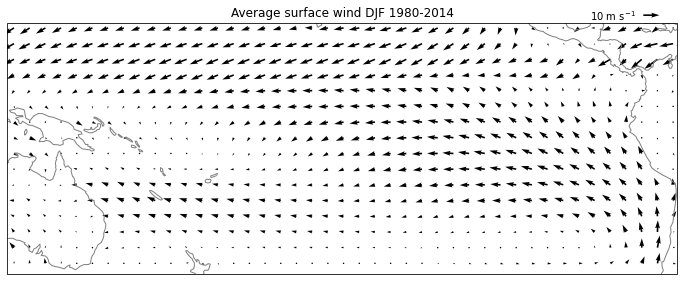

In [61]:
# Plot the total averages
pu = u_djf.mean(dim='year')
pv = v_djf.mean(dim='year')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
pu, pv = pu[::5,::5], pv[::5,::5] 
qv = ax.quiver(pu.longitude, pu.latitude, pu.values, pv.values, transform=ccrs.PlateCarree())
ax.coastlines(color='grey'); 
ax.set_extent([280, 440, 20, -40], crs=ccrs.PlateCarree(central_longitude=210))
plt.title('Average surface wind DJF 1980-2014')
qk = plt.quiverkey(qv, 0.95, 1.03, 10, '10 m s$^{-1}$', labelpos='W')

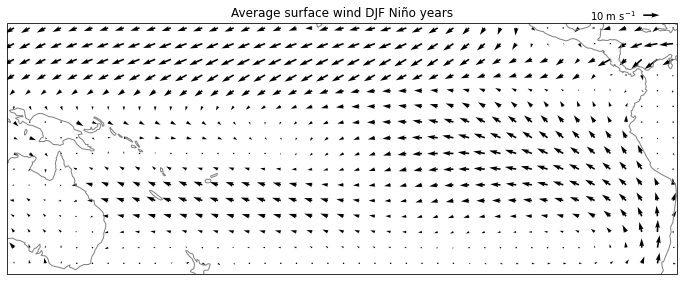

In [62]:
# we now repeat the operation with Niño years only
pu = u_djf.sel(year=nino_yrs).mean(dim='year')
pv = v_djf.sel(year=nino_yrs).mean(dim='year')
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
pu, pv = pu[::5,::5], pv[::5,::5] 
qv = ax.quiver(pu.longitude, pu.latitude, pu.values, pv.values, transform=ccrs.PlateCarree())
ax.coastlines(color='grey'); 
ax.set_extent([280, 440, 20, -40], crs=ccrs.PlateCarree(central_longitude=210))
plt.title('Average surface wind DJF Niño years')
qk = plt.quiverkey(qv, 0.95, 1.03, 10, '10 m s$^{-1}$', labelpos='W')

**Q: analyse the differences between the two plots. Hard to spot, right?**

**E: now compute and plot the composite anomaly of the wind field during Niño years with respect to the non Niño years average. Plot it with quiver(). Analyse.**

*Note that you'll have to change the legend of the plot!*

In [64]:
# your answer here

**Anomalies of the wind field are not trivial to interpret! See for example the westerly anomalies of the wind at the equator: they match our conceptual model from the lecture quite well, but in reality the winds are still easterly on average, even during Niño years!**

## One-point correlation maps 

With this simple example we seek to reproduce the one-point correlation map with SLP at Darwin, that we showed during the lecture:

<img src="https://www.dropbox.com/s/b1njlzdwn5vr5zs/darwin_thaiti.png?dl=1" width="60%">

In [65]:
# new data file, available on OLAT or on the scratch directory
ds = xr.open_dataset('../data/ERA5_LowRes_Monthly_uvslp.nc')

In [66]:
# compute the annual average
slp = ds.msl.load().resample(time='AS').mean(dim='time') / 100.
# take the SLP at Darwin
slp_da = slp.sel(latitude=-12.45, longitude=130, method='nearest')

In [67]:
# make an empty array that we will fill
cor_map = slp.isel(time=0) * 0.
# loop over lats and lons
for j in np.arange(len(ds.latitude)):
    for i in np.arange(len(ds.longitude)):
        # we use the .values attribute because this is much faster
        cor_map.values[j, i] = np.corrcoef(slp.values[:, j, i], slp_da.values)[0, 1]

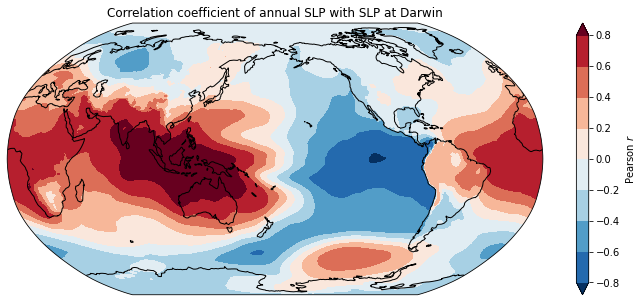

In [68]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-180))
cor_map.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=np.linspace(-0.8, 0.8, 9), 
                      extend='both', cbar_kwargs={'label':'Pearson $r$'});
ax.coastlines(); ax.set_global();
plt.title('Correlation coefficient of annual SLP with SLP at Darwin');